In [1]:
import pandas as pd
import numpy as np
import os, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
labels = pd.read_csv('results.csv')
labels.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0


In [4]:
#separating model lables
male_data = labels[labels['Gender'] == 0]
male_data.head()

,Filename,Gender
2,Raw_0003_003_20050913094955_Portrait.png,0
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0


In [5]:
#splitting male data into trin and test
test_male_data = male_data.iloc[-3:,:]
train_male_data = male_data.iloc[:-3,:]

In [6]:
#Separatinf females labels 
female_data = labels[labels['Gender'] ==1]
female_data.head()

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
3,Raw_0005_004_20050913101316_Portrait.png,1
9,Raw_0014_010_20050913093018_Portrait.png,1
22,Raw_0039_023_20050913110844_Portrait.png,1


In [7]:
#splitting female data into trin and test
test_female_data = female_data.iloc[-3:,:]
train_female_data = female_data.iloc[:-3,:]

In [8]:
#total test data
test_indices = test_female_data.index.tolist() + test_male_data.index.tolist()
test_data = labels.iloc[test_indices,:]

In [9]:
#total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)

In [10]:
train_data

,Filename,Gender
0,Raw_0001_001_20050913115022_Portrait.png,1
1,Raw_0002_002_20050913094354_Portrait.png,1
2,Raw_0003_003_20050913094955_Portrait.png,0
3,Raw_0005_004_20050913101316_Portrait.png,1
4,Raw_0007_005_20050913093707_Portrait.png,0
5,Raw_0009_006_20050913122608_Portrait.png,0
6,Raw_0010_007_20050913094809_Portrait.png,0
7,Raw_0011_008_20050913123954_Portrait.png,0
8,Raw_0012_009_20050913095944_Portrait.png,0
9,Raw_0014_010_20050913093018_Portrait.png,1


In [11]:
path = '/home/rukesh/Documents/classification/gender/'

In [12]:
training_data_filename_list = train_data['Filename'].values.tolist()
testing_data_filename_list = test_data['Filename'].values.tolist()
train_image_name = []
test_image_name = []
path = path + 'final/'
for file in training_data_filename_list:
    train_image_name.append(path+file)
for file in testing_data_filename_list:
    test_image_name.append(path+file)

In [13]:
train_image_name[0]

'/home/rukesh/Documents/classification/gender/final/Raw_0001_001_20050913115022_Portrait.png'

In [14]:
# preparing data by processing images using opencv
ROWS = 64
COLS = 64
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count,ROWS, COLS,CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
    return data

train = prep_data(train_image_name)
test = prep_data(test_image_name)

In [15]:
print(train.shape)

(110, 64, 64, 3)


In [16]:
optimizer = RMSprop(lr=1e-4)
model = Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(ROWS, COLS,3), activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/home/rukesh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3...)`
  after removing the cwd from sys.path.
/home/rukesh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/home/rukesh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  
/home/rukesh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/home/rukesh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)      

In [18]:
labels = train_data.iloc[:,1].values.tolist()
model.fit(train, labels, batch_size=32, epochs=20,
              validation_split=0.25, verbose=1, shuffle=True)


Train on 82 samples, validate on 28 samples
Epoch 1/20
82/82 [==============================] - 2s 20ms/step - loss: 1.6855 - accuracy: 0.6098 - val_loss: 0.5628 - val_accuracy: 0.7143
Epoch 2/20
82/82 [==============================] - 1s 13ms/step - loss: 0.9860 - accuracy: 0.6463 - val_loss: 0.5913 - val_accuracy: 0.7143
Epoch 3/20
82/82 [==============================] - 1s 14ms/step - loss: 0.7773 - accuracy: 0.6829 - val_loss: 0.5869 - val_accuracy: 0.7143
Epoch 4/20
82/82 [==============================] - 1s 14ms/step - loss: 0.6590 - accuracy: 0.6341 - val_loss: 0.5375 - val_accuracy: 0.7143
Epoch 5/20
82/82 [==============================] - 1s 14ms/step - loss: 0.5454 - accuracy: 0.7073 - val_loss: 0.8186 - val_accuracy: 0.7143
Epoch 6/20
82/82 [==============================] - 1s 14ms/step - loss: 0.5711 - accuracy: 0.7561 - val_loss: 0.5179 - val_accuracy: 0.7143
Epoch 7/20
82/82 [==============================] - 1s 14ms/step - loss: 0.6034 - accuracy: 0.6951 - val_loss

In [20]:
predictions = model.predict(test)
predictions

array([[0.8201473 ],
       [0.77094   ],
       [0.6223547 ],
       [0.42783827],
       [0.52725834],
       [0.04552036]], dtype=float32)

I am 82.01% sure this is a Female


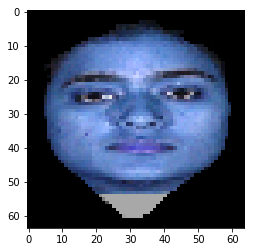

I am 77.09% sure this is a Female


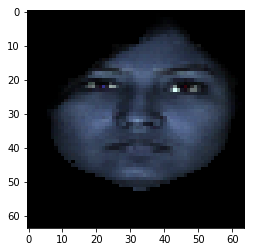

I am 62.24% sure this is a Female


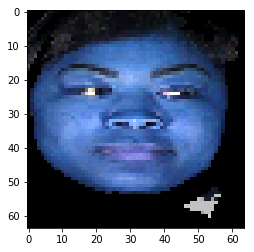

I am 57.22% sure this is a Male


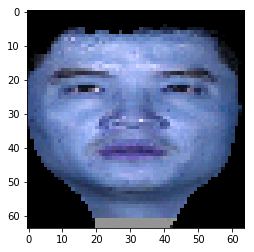

I am 52.73% sure this is a Female


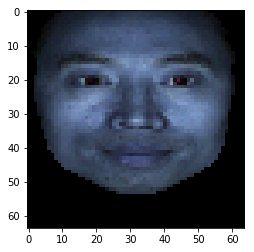

I am 95.45% sure this is a Male


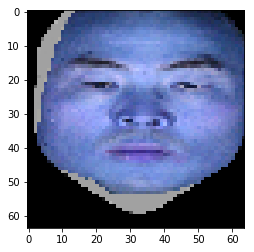

In [21]:
for i in range(0,6):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()

In [ ]:
model.save('classification.h5')